# Overview
This notebook takes a list of top-studied human proteins, downloads PDB structures from AlphaFold to assess their quality, and representatively samples 25 proteins from that list. We used these 25 proteins to perform a meta-analysis of ProteinCartography results to identify the limits of the pipeline's current functionalities.

# 0. Setup

The `most_studied_human_proteins.tsv` file was genereated by manually copying the proteins listed in Table 1 and Table 2 of this paper: [Li and Buck 2021, Protein Science](https://doi.org/10.1002/pro.4038) and aggregating their UniProt identifiers.

In [1]:
#######################
# Import dependencies #
#######################
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

##################################
# Load Arcadia-specific packages #
##################################
import sys

# set up specialized functions
sys.path.append('../ProteinCartography/')
from fetch_accession import fetch_pdb
from assess_pdbs import assess_pdbs

# set up colors and plot scheme
import arcadia_pycolor as apc
apc.mpl_setup()

########################
# Set global variables #
########################
output_dir = 'pub_proteins'

# create output directory if it doesn't already exist
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# 1. Downloading and assessing PDBs

We include the `most_studied_human_proteins.tsv` file as part of this GitHub repository.  
This block downloads a PDB structure for each protein in the dataset and assesses the proteins to determine the [mean pLDDT](https://alphafold.ebi.ac.uk/faq#faq-5) of their structures, which is a heuristic for structure quality.

In [2]:
# read input TSV and display it
proteins_df = pd.read_csv('most_studied_human_proteins.tsv', sep = '\t')
display(proteins_df)

# extract list of uniprot IDs
proteins_list = proteins_df['uniprot id'].values

# download PDB files for all of the proteins from AlphaFold    
for protid in tqdm(proteins_list):
    if not os.path.exists(os.path.join(output_dir, f'{protid}.pdb')):
        fetch_pdb(protid, output_dir)

# get list of file paths to those PDBs
protein_file_list = [os.path.join(output_dir, i) for i in os.listdir(output_dir) if '.pdb' in i]

# calculate mean pLDDT for each
assessment_df = assess_pdbs(protein_file_list, os.path.join(output_dir, 'pub_proteins_analysis.tsv'))
display(assessment_df)

,uniprot id,protein,Length
0,P31947,14–3-3 protein sigma,248
1,O15530,3-phosphoinositide-dependent protein kinase 1,556
2,P08708,40S ribosomal protein S17,135
3,P62266,40S ribosomal protein S23,143
4,P62753,40S ribosomal protein S6,249
...,...,...,...
188,P00749,Urokinase-type plasminogen activator,431
189,P35968,Vascular endothelial growth factor receptor 2,1356
190,P11473,Vitamin D3 receptor,427
191,P40337,von Hippel–Lindau disease tumor suppressor,213


100%|██████████| 193/193 [00:00<00:00, 1776.07it/s]


,protid,pdb_origin,pdb_confidence,pdb_chains
0,P08603,AlphaFold,79.112146,[A]
1,P40337,AlphaFold,85.590887,[A]
2,P28074,AlphaFold,83.014641,[A]
3,P14174,AlphaFold,98.594309,[A]
4,P62753,AlphaFold,94.005390,[A]
...,...,...,...,...
182,P18031,AlphaFold,82.030609,[A]
183,P29373,AlphaFold,96.710100,[A]
184,P0DP23,AlphaFold,85.087947,[A]
185,P25788,AlphaFold,94.693955,[A]


# 3. Combine data

This cell merges the two DataFrames into one.

In [3]:
proteins_df.rename(columns = {'uniprot id': 'protid'}, inplace = True)

merged_df = proteins_df.merge(assessment_df, on = 'protid', how = 'right')
display(merged_df)

,protid,protein,Length,pdb_origin,pdb_confidence,pdb_chains
0,P08603,Complement factor H,1231,AlphaFold,79.112146,[A]
1,P40337,von Hippel–Lindau disease tumor suppressor,213,AlphaFold,85.590887,[A]
2,P28074,Proteasome subunit beta type-5,263,AlphaFold,83.014641,[A]
3,P14174,Macrophage migration inhibitory factor,115,AlphaFold,98.594309,[A]
4,P62753,40S ribosomal protein S6,249,AlphaFold,94.005390,[A]
...,...,...,...,...,...,...
182,P18031,Tyrosine-protein phosphatase non-receptor type 1,435,AlphaFold,82.030609,[A]
183,P29373,Cellular retinoic acid-binding protein 2,138,AlphaFold,96.710100,[A]
184,P0DP23,Calmodulin-1,149,AlphaFold,85.087947,[A]
185,P25788,Proteasome subunit alpha type-3,255,AlphaFold,94.693955,[A]


# 4. Inspect data

This cell generates a plot that contains distributions of pLDDT and protein length, as well as a scatter plot comparing pLDDT and protein length.

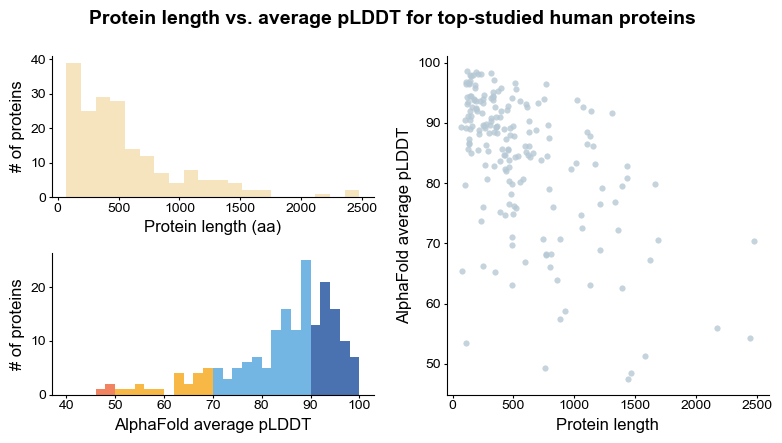

In [4]:
# make figure
plt.figure(figsize = (8, 4.5))

# create subplot grid
plt.subplot(2, 2, 1)

# plot histogram of protein lengths
plt.hist(merged_df['Length'], bins = 20, color = 'arcadia:oat')
plt.xlabel('Protein length (aa)')
plt.ylabel('# of proteins')

# plot histogram of pLDDT scores
plt.subplot(2, 2, 3)
n, bins, patches = plt.hist(merged_df['pdb_confidence'], bins = np.arange(40, 101, 2), color = 'arcadia:amber')

for bn, p in zip(bins, patches):
    if bn >= 90:
        plt.setp(p, 'facecolor', '#4A72B0')
    elif bn >= 70:
        plt.setp(p, 'facecolor', apc.All['arcadia:vitalblue'])
    elif bn >= 50:
        plt.setp(p, 'facecolor', apc.All['arcadia:canary'])
    else:
        plt.setp(p, 'facecolor', apc.All['arcadia:amber'])
plt.xlabel('AlphaFold average pLDDT')
plt.ylabel('# of proteins')

# plot scatterplot of protein length vs. pLDDT
plt.subplot(1, 2, 2)
plt.scatter(x = merged_df['Length'], y = merged_df['pdb_confidence'], s = 20, alpha = 0.8, color = 'arcadia:denim')

plt.xlabel('Protein length')
plt.ylabel('AlphaFold average pLDDT')

# set global parameters
plt.suptitle('Protein length vs. average pLDDT for top-studied human proteins')
plt.tight_layout()

# save figure and show
plt.savefig('top_studied_proteins_distribution.svg')
plt.show()

## Look at top 10 longest and highest quality proteins

In [5]:
merged_df.sort_values('Length', ascending = False).head(10)

,protid,protein,Length,pdb_origin,pdb_confidence,pdb_chains
126,P02751,Fibronectin,2477,AlphaFold,70.332757,[A]
118,Q92793,CREB-binding protein,2442,AlphaFold,54.295475,[A]
28,Q9UIF8,Bromodomain adjacent to zinc finger domain pro...,2168,AlphaFold,55.871608,[A]
157,P29375,Lysine-specific histone demethylase 1A,1690,AlphaFold,70.565702,[A]
29,P01024,Complement C3,1663,AlphaFold,79.812489,[A]
94,Q9UM73,ALK tyrosine kinase receptor,1620,AlphaFold,67.276466,[A]
170,Q15648,Mediator of RNA polymerase II transcription su...,1581,AlphaFold,51.295623,[A]
65,Q15596,Nuclear receptor coactivator 2,1464,AlphaFold,48.459262,[A]
111,Q15788,Nuclear receptor coactivator 1,1441,AlphaFold,47.389764,[A]
116,P29475,"Nitric oxide synthase, brain",1434,AlphaFold,80.829277,[A]


In [6]:
merged_df.sort_values('pdb_confidence', ascending = False).head(10)

,protid,protein,Length,pdb_origin,pdb_confidence,pdb_chains
3,P14174,Macrophage migration inhibitory factor,115,AlphaFold,98.594309,[A]
18,Q99497,Parkinson disease protein 7,189,AlphaFold,98.419174,[A]
12,P15121,Aldo-keto reductase family 1 member B1,316,AlphaFold,98.309818,[A]
113,P16083,Ribosyldihydronicotinamide dehydrogenase [quin...,231,AlphaFold,98.174401,[A]
83,P09211,Glutathione S-transferase P,210,AlphaFold,98.070115,[A]
106,P69905,Hemoglobin subunit alpha,142,AlphaFold,98.029907,[A]
88,P62937,Peptidyl-prolyl cis-trans isomerase A,165,AlphaFold,98.024976,[A]
178,P00441,Superoxide dismutase [cu-Zn],154,AlphaFold,97.821216,[A]
81,P62873,Guanine nucleotide-binding protein G(I)/G(S)/G...,340,AlphaFold,97.213644,[A]
38,P68871,Hemoglobin subunit beta,147,AlphaFold,96.969726,[A]


# 5. Sample proteins representatively based on bins of length and pdb confidence

In [7]:
# assign each protein to an equally-sized bin for Length or pdb_confidence
merged_df['Length_bin'] = pd.qcut(merged_df['Length'], 10, [i for i in range(1, 11)])
merged_df['pdb_confidence_bin'] = pd.qcut(merged_df['pdb_confidence'], 10, [i for i in range(1, 11)])

# generate combined binning for value counting
# see: https://stackoverflow.com/questions/64967847/pandas-representative-sampling-across-multiple-columns
merged_df['combined'] = list(zip(merged_df['Length_bin'], merged_df['pdb_confidence_bin']))

# generate value counts for zipped weights, normalizing to get weight
combined_weight = merged_df['combined'].value_counts(normalize = True)
# map weights back to combined value
merged_df['combined_weight'] = merged_df['combined'].apply(lambda x: combined_weight[x])

# sample using weights
merged_df_sample = merged_df.sample(25, weights=merged_df['combined_weight'], random_state = 20230821)

# indicate in original data whether or not a protein was sampled
merged_df['sampled'] = merged_df['protid'].apply(lambda x: 'yes' if x in merged_df_sample['protid'].values else 'no')

display(merged_df)
display(merged_df_sample)

# output sampled proteins to a TSV
merged_df.to_csv('most_studied_human_proteins_analysis.tsv', sep = '\t')
merged_df_sample.to_csv('sampled_proteins.tsv', sep = '\t')

,protid,protein,Length,pdb_origin,pdb_confidence,pdb_chains,Length_bin,pdb_confidence_bin,combined,combined_weight,sampled
0,P08603,Complement factor H,1231,AlphaFold,79.112146,[A],10,3,"(10, 3)",0.032086,yes
1,P40337,von Hippel–Lindau disease tumor suppressor,213,AlphaFold,85.590887,[A],3,5,"(3, 5)",0.005348,yes
2,P28074,Proteasome subunit beta type-5,263,AlphaFold,83.014641,[A],4,4,"(4, 4)",0.010695,yes
3,P14174,Macrophage migration inhibitory factor,115,AlphaFold,98.594309,[A],1,10,"(1, 10)",0.026738,yes
4,P62753,40S ribosomal protein S6,249,AlphaFold,94.005390,[A],3,9,"(3, 9)",0.021390,no
...,...,...,...,...,...,...,...,...,...,...,...
182,P18031,Tyrosine-protein phosphatase non-receptor type 1,435,AlphaFold,82.030609,[A],6,3,"(6, 3)",0.026738,no
183,P29373,Cellular retinoic acid-binding protein 2,138,AlphaFold,96.710100,[A],1,10,"(1, 10)",0.026738,no
184,P0DP23,Calmodulin-1,149,AlphaFold,85.087947,[A],2,5,"(2, 5)",0.005348,no
185,P25788,Proteasome subunit alpha type-3,255,AlphaFold,94.693955,[A],3,9,"(3, 9)",0.021390,no


,protid,protein,Length,pdb_origin,pdb_confidence,pdb_chains,Length_bin,pdb_confidence_bin,combined,combined_weight
94,Q9UM73,ALK tyrosine kinase receptor,1620,AlphaFold,67.276466,[A],10,1,"(10, 1)",0.037433
17,P98170,E3 ubiquitin-protein ligase XIAP,497,AlphaFold,74.874344,[A],7,2,"(7, 2)",0.010695
26,P49841,Glycogen synthase kinase-3 beta,420,AlphaFold,89.045659,[A],5,6,"(5, 6)",0.021390
19,Q93009,Ubiquitin carboxyl-terminal hydrolase 7,1102,AlphaFold,86.436554,[A],9,5,"(9, 5)",0.010695
96,O75530,Polycomb protein EED,441,AlphaFold,87.337825,[A],6,5,"(6, 5)",0.016043
152,P53779,Mitogen-activated protein kinase 10,464,AlphaFold,80.358883,[A],6,3,"(6, 3)",0.026738
56,Q13451,Peptidyl-prolyl cis-trans isomerase FKBP5,457,AlphaFold,92.878441,[A],6,8,"(6, 8)",0.010695
178,P00441,Superoxide dismutase [cu-Zn],154,AlphaFold,97.821216,[A],2,10,"(2, 10)",0.037433
65,Q15596,Nuclear receptor coactivator 2,1464,AlphaFold,48.459262,[A],10,1,"(10, 1)",0.037433
50,P19793,Retinoic acid receptor RXR-alpha,462,AlphaFold,76.512264,[A],6,3,"(6, 3)",0.026738


# 6. Plot distribution of proteins that were sampled as interactive HTML

In [8]:
fig = px.scatter(
    merged_df, 
    x = 'Length', 
    y = 'pdb_confidence', 
    marginal_x = 'histogram',
    marginal_y = 'histogram',
    color = 'sampled', 
    hover_name = 'protid', 
    hover_data = ['protein', 'Length', 'pdb_confidence'], 
    opacity = 0.8, 
    category_orders = {'sampled': ['no', 'yes']},
    color_discrete_map = {'yes': apc.All['arcadia:dragon'], 'no': apc.All['arcadia:brightgrey']}
)

#fig.update_traces(marker_color = apc.All['arcadia:aegean'])
fig.update_layout(
    plot_bgcolor = apc.All['arcadia:paper'],
    width = 600,
    height = 570,
    font_family = 'Arial'
)
fig.show()

fig.write_html('sampled_proteins.html')